# Converting Last.fm tags to genre annotations

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import csv
import collections
import json

## Load genre taxonomy

In [3]:
def flatten_tree(elem, path, branches):
    """Flatten nested lists/dictionaries into lists of strings
    (branches).
    """
    if not path:
        path = []

    if isinstance(elem, dict):
        for (k, v) in elem.items():
            flatten_tree(v, path + [k], branches)
    elif isinstance(elem, list):
        for sub in elem:
            flatten_tree(sub, path, branches)
    else:
        branches.append(path + [unicode(elem)])

def load_genre_taxonomy(taxonomy_file):
    import yaml
    genres_tree = yaml.load(open(taxonomy_file, 'r'))
    genres = []
    flatten_tree(genres_tree, [], genres)
    
    # Build a genre dictionary from the genre parent list.
    # This is {'subgenre': parent, 'subsubgenre': parent}
    genre_d = {}
    for g in genres:
        d = collections.deque(reversed(g))
        while True:
            try:
                g = d.popleft()
                r = list(d)
                if not r:
                    r = [g]
                genre_d[g] = r[-1]
            except IndexError:
                break
    return genre_d

In [4]:
genre_d = load_genre_taxonomy("jamendo-beets-genres-tree.yaml")

## Load Last.fm-AB tags corpus

In [5]:
def lastfm_ab_stats(filename):
    tree_counter = collections.Counter()
    lfmf = csv.reader(open(filename), delimiter='\t')
    n_mbids = 0
    n_mbids_annotated = 0
    unique_tags = set()
    for l in lfmf:
        if l:
            n_mbids += 1
        tags = eval(l[1])
        if len(tags):
            n_mbids_annotated += 1
        for t in tags:
            t = t[0].lower()
            unique_tags.add(t)
            if t in genre_d:
                tree_counter[genre_d[t]] += 1

    print("Found tags for", n_mbids_annotated, "out of", n_mbids, "MBIDs")
    print("Total number of tags:", sum(tree_counter.values()))
    print("Number of unique tags:", len(unique_tags))
    print()
    print("Tag counts per top-level genre category:")
    print(tree_counter.most_common())         
                
lastfm_ab_stats("gt_crosseval.tsv")

Found tags for 28434 out of 28434 MBIDs
Total number of tags: dict_values([5724, 18028, 347, 216, 7230, 25473, 2089, 5544, 3030, 1312, 2407, 556, 7306, 527, 5109, 3313, 257, 766, 2536, 948, 67, 90, 103])
Number of unique tags: 92240

Tag counts per top-level genre category:
[('electronic', 25473), ('rock', 18028), ('alternative rock', 7306), ('pop', 7230), ('jazz', 5724), ('rhythm and blues', 5544), ('metal', 5109), ('country', 3313), ('dance', 3030), ('blues', 2536), ('folk', 2407), ('hip hop', 2089), ('easy listening', 1312), ('disco', 948), ('caribbean and latin american', 766), ('avant-garde', 556), ('classical', 527), ('ska', 347), ('other', 257), ('reggae', 216), ('comedy', 103), ('african', 90), ('asian', 67)]



### Annotation by top-level genres

We remove tags that don't match to a top level genre category, and sum tag weights that share a common top level category. Because we remove and merge tags, the highest weighted tag is now not necesseraly equal to 100. After inspecting the distribution of the highest weighted tags, we chose to remove recordings where the weight of the top tag was less than 30. Then we re-weight tags so that the top tag is always 100. This lets us decide if a match on a secondary tag is significant or not, as it will represent the percentage of the top tag. Again, we discard tags with new weights less than 30. We suppose that this way we ensure the robustness of the genre tag annotation.


In [6]:
def find_parent_tags(tags):
    merged = collections.Counter()
    for t, weight in tags:
        t = t.lower()
        if t in genre_d and weight:
            merged[genre_d[t]] += int(weight)
    return merged

def merge_tags(filename):
    merged_tags = {}
    lfmf = csv.reader(open(filename), delimiter='\t')
    for l in lfmf:
        tags = eval(l[1])
        mbid = l[0]
        ps = find_parent_tags(tags)
        if len(ps):
            merged_tags[mbid] = ps.most_common()
    return merged_tags
            
def discard_by_toptag_weight(tags, weight=30):
    cleaned_tags = {}
    for mbid, tagweights in tags.items():
        for t,w in tagweights:
            if w >= weight:
                cleaned_tags[mbid] = tagweights
                break
            else:
                break
    return cleaned_tags
    
def discard_by_tag_weight(tags, weight=30):
    cleaned_tags = {}
    for mbid, tagweights in tags.items():
        cleaned = []
        for t,w in tagweights:
            if w >= weight:
                cleaned.append((t,w))
            else:
                break
        if cleaned:
            cleaned_tags[mbid] = cleaned
    return cleaned_tags
            
def normalize_weights(tags):
    weighted_tags = {}
    for k, v in tags.items():
        maxweight = v[0][1]
        tags = []
        for t, w in v:
            w = int(w*100.0/maxweight)
            tags.append([t, w])
        weighted_tags[k] = tags
    return weighted_tags

def weights_stats_count(tags, weight):
    multitags = 0
    discard = 0  
    keep = 0
    for k, v in tags.items():
        if len(v) > 1:
            multitags += 1
            w1 = v[0][1]
            w2 = v[1][1]
            if w2 < weight:
                discard += 1
            else:
                keep += 1
    
    print("number of MBIDs with >1 tag", multitags)
    print("number of MBIDs with second tag's weight < %f: %d (%f percent)" % (weight, discard, discard*100.0/len(tags)))
    print("after discarding, %d tracks will still have multiple tags" % keep)
    print("---")
    
def weights_stats(tags):
    weights = []
    weights_all = []
    for k, v in tags.items():
        weights.append(v[0][1])
        weights_all.extend([w[1] for w in v])
    print ("Maximum weight found:", max(weights))
    pylab.hist([w for w in weights if w < 100], 20)
    print ("Distribution of the top-tag weights < 100")
    pylab.show()
    
    pylab.hist([w for w in weights_all if w < 100], 20)
    print ("Distribution of tag weights < 100")
    pylab.show()
    
    hist = []
    for k, v in tags.items():
        if len(v) > 1 and v[0][1] > 30:
            count_2 = v[1][1]
            count_1 = v[0][1]
            if count_1:
                ratio = (count_2*1.0/count_1)*100
                #bin = int(ratio)/10*10
                hist.append(int(ratio))
    pylab.hist(hist, 20, cumulative=True, stacked=True)
    print("Cumulative histogram of ratios between second tag and first tag for MBIDs with multiple tags")
    pylab.show()

    weights_stats_count(tags, 10)
    weights_stats_count(tags, 20)
    weights_stats_count(tags, 30)

=== MERGING TAGS ===
Created merged annotations for 26062 MBIDs
Maximum weight found: 2000
Distribution of the top-tag weights < 100


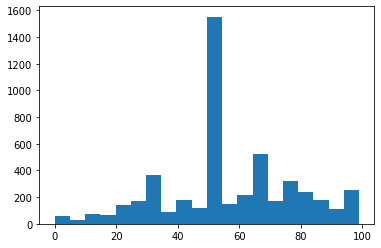

Distribution of tag weights < 100


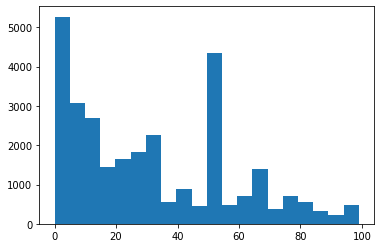

Cumulative histogram of ratios between second tag and first tag for MBIDs with multiple tags


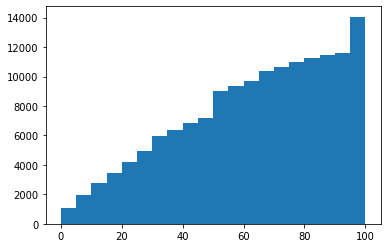

number of MBIDs with >1 tag 14394
number of MBIDs with second tag's weight < 10.000000: 1436 (5.509938 percent)
after discarding, 12958 tracks will still have multiple tags
---
number of MBIDs with >1 tag 14394
number of MBIDs with second tag's weight < 20.000000: 2881 (11.054409 percent)
after discarding, 11513 tracks will still have multiple tags
---
number of MBIDs with >1 tag 14394
number of MBIDs with second tag's weight < 30.000000: 4475 (17.170593 percent)
after discarding, 9919 tracks will still have multiple tags
---
=== REMOVE MBIDS WITH TOP TAG WEIGHT < 30 AND NORMALIZE ===
Discarded MBIDs with count of first tag < 30: 535 ( 2.0527971759650065 % )

Tag weight distribution after re-weighting
Maximum weight found: 100
Distribution of the top-tag weights < 100


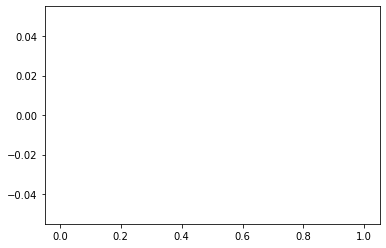

Distribution of tag weights < 100


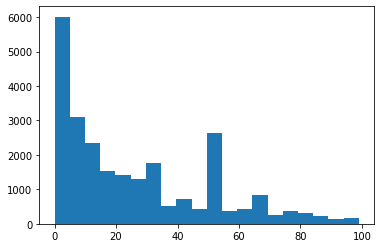

Cumulative histogram of ratios between second tag and first tag for MBIDs with multiple tags


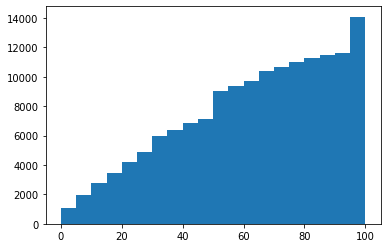

number of MBIDs with >1 tag 14079
number of MBIDs with second tag's weight < 10.000000: 1932 (7.568457 percent)
after discarding, 12147 tracks will still have multiple tags
---
number of MBIDs with >1 tag 14079
number of MBIDs with second tag's weight < 20.000000: 3470 (13.593450 percent)
after discarding, 10609 tracks will still have multiple tags
---
number of MBIDs with >1 tag 14079
number of MBIDs with second tag's weight < 30.000000: 4913 (19.246288 percent)
after discarding, 9166 tracks will still have multiple tags
---
=== REMOVE TAGS WITH WEIGHT < 30 ===
=== ANNOTATION DONE ===
Resulting number of annotated MBIDs: 25527
Total number of top-level genre tags: 37388


In [7]:
print("=== MERGING TAGS ===")
merged_tags = merge_tags("gt_crosseval.tsv")
print("Created merged annotations for", len(merged_tags), "MBIDs")
    
weights_stats(merged_tags)

print("=== REMOVE MBIDS WITH TOP TAG WEIGHT < 30 AND NORMALIZE ===")
cleaned_tags = discard_by_toptag_weight(merged_tags, 30)
discarded = len(merged_tags) - len(cleaned_tags)
print("Discarded MBIDs with count of first tag < 30:", discarded, "(", discarded*100.0/len(merged_tags), "% )")
print()

weighted_tags = normalize_weights(cleaned_tags)

print("Tag weight distribution after re-weighting")
weights_stats(weighted_tags)

print("=== REMOVE TAGS WITH WEIGHT < 30 ===")
cleaned_weighted_tags = discard_by_tag_weight(weighted_tags, 30)
discarded = len(weighted_tags) - len(cleaned_weighted_tags)
print

print("=== ANNOTATION DONE ===")
print("Resulting number of annotated MBIDs:", len(cleaned_weighted_tags))

numtags = 0
for k, v in cleaned_weighted_tags.items():
    numtags += len(v)
print("Total number of top-level genre tags:", numtags)



In [29]:
cleaned_weighted_tags.values()

dict_values([[('jazz', 100)], [('rock', 100)], [('rock', 100), ('ska', 39)], [('rock', 100), ('electronic', 33)], [('hip hop', 100)], [('rock', 100)], [('electronic', 100)], [('rhythm and blues', 100)], [('electronic', 100)], [('electronic', 100)], [('rhythm and blues', 100)], [('folk', 100), ('rock', 55)], [('rhythm and blues', 100), ('pop', 100)], [('rhythm and blues', 100), ('jazz', 66)], [('rock', 100)], [('electronic', 100), ('classical', 66)], [('rock', 100)], [('pop', 100), ('rock', 39)], [('hip hop', 100)], [('pop', 100)], [('country', 100)], [('hip hop', 100)], [('hip hop', 100)], [('pop', 100), ('rhythm and blues', 50)], [('rock', 100)], [('electronic', 100)], [('rhythm and blues', 100)], [('ska', 100), ('rock', 100)], [('rock', 100)], [('rock', 100), ('country', 40)], [('rock', 100)], [('rock', 100)], [('folk', 100)], [('rock', 100)], [('blues', 100)], [('rhythm and blues', 100), ('pop', 100)], [('rock', 100)], [('rock', 100)], [('rock', 100)], [('pop', 100)], [('rock', 100)

In [8]:
json.dump(cleaned_weighted_tags, open("lastfm-audio-genres-clean.json", "w"))

## Number of MBIDs per top-level genre in resulting annotation

In [23]:
import collections
class_counts = collections.Counter()
for k, v in cleaned_weighted_tags.items():
    for t, w in v:
        class_counts[t] += 1
class_counts.most_common()

[('rock', 10294),
 ('electronic', 6717),
 ('pop', 3839),
 ('jazz', 2841),
 ('rhythm and blues', 2071),
 ('country', 1600),
 ('folk', 1493),
 ('blues', 1145),
 ('hip hop', 832),
 ('easy listening', 362),
 ('caribbean and latin american', 307),
 ('avant-garde', 213),
 ('ska', 191),
 ('classical', 144),
 ('african', 60),
 ('other', 35),
 ('asian', 33),
 ('comedy', 32)]

### Among MBIDs with a single top-genre tag only

In [27]:
no_conflict_class_counts = collections.Counter()
for k, v in cleaned_weighted_tags.items():
    if len(v) >0:
        t = v[0][0]
        no_conflict_class_counts[t] += 1
all_genres = no_conflict_class_counts.most_common()

print("--- number of MBIDs ---")
for k, v in no_conflict_class_counts.most_common():
    print("%s & %s \\\\" % (k.title(), v))
print()
print("--- % of MBIDs ---")
total_tracks = len(dict(all_genres).values())
for k, v in no_conflict_class_counts.most_common():
    print("%s & %.2f \\\\" % (k.title(), round(v*100.0/total_tracks, 2)))

--- number of MBIDs ---
Rock & 8673 \\
Electronic & 5221 \\
Pop & 2485 \\
Jazz & 2480 \\
Rhythm And Blues & 1525 \\
Country & 1319 \\
Folk & 1076 \\
Blues & 875 \\
Hip Hop & 651 \\
Easy Listening & 192 \\
Caribbean And Latin American & 138 \\
Ska & 92 \\
Classical & 68 \\
Avant-Garde & 51 \\
African & 32 \\
Asian & 22 \\
Comedy & 15 \\
Other & 5 \\

--- % of MBIDs ---
Rock & 48183.33 \\
Electronic & 29005.56 \\
Pop & 13805.56 \\
Jazz & 13777.78 \\
Rhythm And Blues & 8472.22 \\
Country & 7327.78 \\
Folk & 5977.78 \\
Blues & 4861.11 \\
Hip Hop & 3616.67 \\
Easy Listening & 1066.67 \\
Caribbean And Latin American & 766.67 \\
Ska & 511.11 \\
Classical & 377.78 \\
Avant-Garde & 283.33 \\
African & 177.78 \\
Asian & 122.22 \\
Comedy & 83.33 \\
Other & 27.78 \\


In [18]:
cleaned_weighted_tags['24a1c632-303f-4d12-b3bd-d33977d975c4']

[('jazz', 100)]